In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

In [3]:
def findFiles(path):
    return glob.glob(path)


In [5]:
import unicodedata
import string

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

In [6]:
def unicodeToAscii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
        and c in all_letters
    )

In [7]:
print(unicodeToAscii("Ślusàrski"))

Slusarski


In [8]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding="utf-8").read().strip().split("\n")
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles("names/data/names/*.txt"):
    category = filename.split("/")[-1].split(".")[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

In [10]:
import torch

def letter_to_index(letter):
    return all_letters.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

In [14]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden()
        self.softmax = nn.LogSoftmax()
        
    def init_hidden(self):
        return (
            Variable(torch.zeros(1, 1, self.hidden_size)),
            Variable(torch.zeros(1, 1, self.hidden_size))
        )
    
    def forward(self, data):
        lstm_out, self.hidden = self.lstm(data, self.hidden)
        result = self.linear(lstm_out.view(len(data), -1))
        result = self.softmax(result)
        return result

In [20]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [45]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0]
    return all_categories[category_i], category_i

In [42]:
learning_rate = 0.005
criterion = nn.NLLLoss()
def train(category_tensor, line_tensor):
    rnn.hidden = rnn.init_hidden()
    rnn.zero_grad()
    output = rnn(line_tensor)
    loss = criterion(output[-1,:], category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output[-1,:], loss.data[0]

In [43]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = English / line = Lowndes
category = Portuguese / line = Ventura
category = Chinese / line = Pang
category = Portuguese / line = Castro
category = English / line = Adlam
category = Polish / line = Pasternack
category = English / line = Draper
category = Korean / line = Choe
category = Vietnamese / line = Lieu
category = German / line = Muller


In [46]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 51s) 2.7940 Babakhanov / Russian ✓
10000 10% (1m 37s) 2.8840 Sitta / Japanese ✗ (Czech)
15000 15% (2m 21s) 2.7892 Noel / Scottish ✗ (French)
20000 20% (3m 11s) 2.5077 Kaza / Vietnamese ✗ (Japanese)
25000 25% (3m 54s) 2.2498 Fournier / French ✓
30000 30% (4m 41s) 4.0724 Vann / Korean ✗ (Dutch)
35000 35% (5m 29s) 1.2792 Phi / Korean ✗ (Vietnamese)
40000 40% (6m 10s) 1.5308 Ruadhain / Irish ✓
45000 45% (6m 54s) 6.2300 Shah / Vietnamese ✗ (Russian)
50000 50% (7m 37s) 0.0877 Sfakianos / Greek ✓
55000 55% (8m 14s) 2.2213 Craig / Arabic ✗ (Scottish)
60000 60% (8m 55s) 1.3240 Pierre / German ✗ (French)
65000 65% (9m 41s) 0.8441 Hyata / Japanese ✓
70000 70% (10m 25s) 1.0061 Mo / Korean ✓
75000 75% (11m 12s) 0.8888 Yi / Korean ✓
80000 80% (12m 1s) 2.9888 Delbosque / French ✗ (Spanish)
85000 85% (12m 42s) 1.7032 Cunningham / Scottish ✗ (English)
90000 90% (13m 24s) 0.0314 Kozlowski / Polish ✓
95000 95% (14m 6s) 0.0235 Kouropoulos / Greek ✓
100000 100% (14m 52s) 1.0757 Homulka / Polish

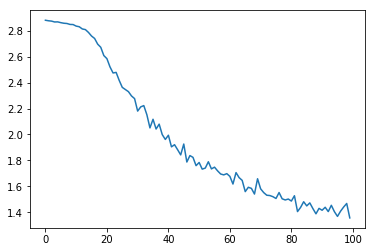

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [48]:
def evaluate(line_tensor):
    rnn.hidden = rnn.init_hidden()
    output = rnn(line_tensor)
    return output[-1,:]

In [60]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))
    # Get top N categories
    topv, topi = output.data.topk(n_predictions)

    for i in range(n_predictions):
        value = topv[i]
        category_index = topi[i]
        print('(%.2f) %s' % (value, all_categories[category_index]))

In [63]:
predict("Dovesky")


> Dovesky
(-0.59) Russian
(-1.34) Czech
(-2.74) Polish


In [64]:
predict("Jackson")


> Jackson
(-0.35) Scottish
(-1.88) English
(-3.09) Czech


In [66]:
predict("Nakamoto")


> Nakamoto
(-0.15) Japanese
(-2.21) Greek
(-4.68) Italian


In [69]:
predict("Schmidhuber")


> Schmidhuber
(-0.45) German
(-2.33) Dutch
(-2.50) Scottish


In [70]:
predict("Hinton")


> Hinton
(-0.73) Scottish
(-1.28) English
(-3.17) Dutch
